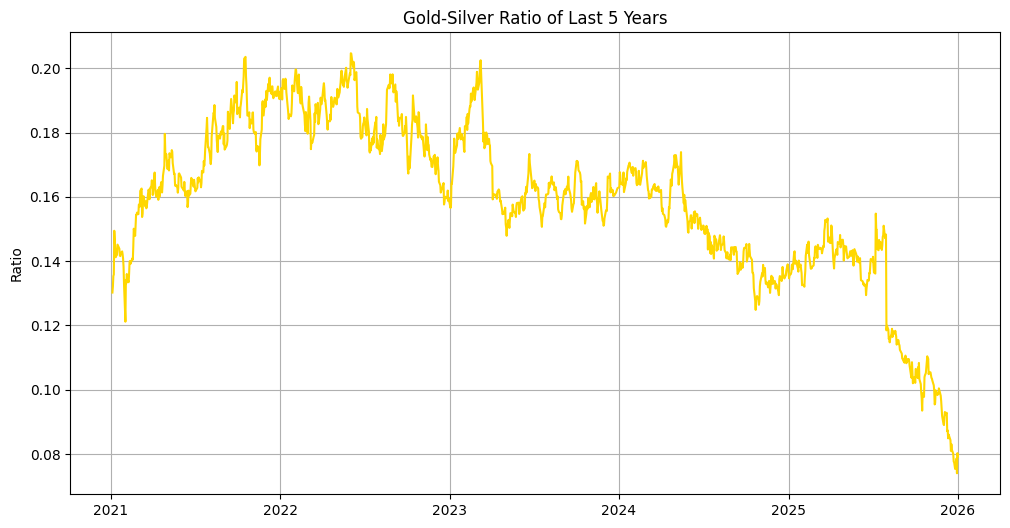

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('../data/metals_data.csv', index_col='Date', parse_dates=True)

# Calculate Log Returns
# np.log(Price / Price_Yesterday)
log_returns = np.log(df / df.shift(1)).dropna()

# Calculate the Gold-Silver Ratio (GSR)
df['GSR'] = df['Gold'] / df['Silver']

# 4. Visualize the GSR
plt.figure(figsize=(12, 6))
plt.plot(df['GSR'], color='gold')
plt.title('Gold-Silver Ratio of Last 5 Years')
plt.ylabel('Ratio')
plt.grid(True)
plt.show()

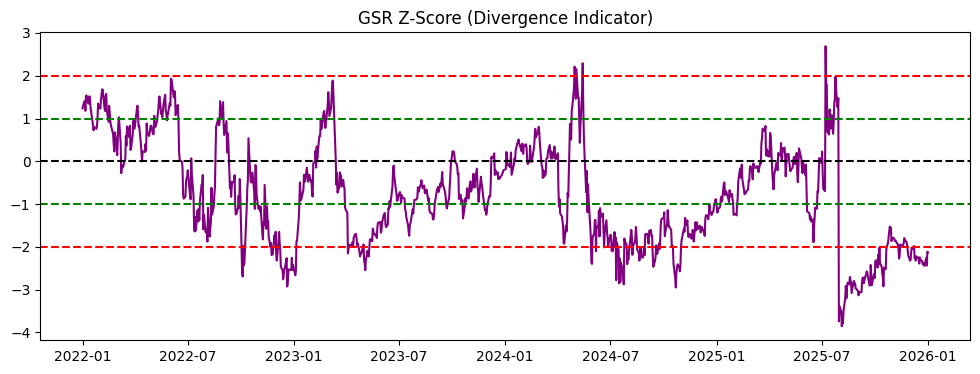

In [4]:
# Calculate the Rolling Mean (Moving Average)
df['GSR_Mean'] = df['GSR'].rolling(window=252).mean() # 252 days = 1 trading year

# Calculate Z-Score (How many standard deviations away from the mean are we
window = 252
rolling_std = df['GSR'].rolling(window=window).std()
df['Z_Score'] = (df['GSR'] - df['GSR_Mean']) / rolling_std

# Plot the Z-Score
plt.figure(figsize=(12, 4))
plt.plot(df['Z_Score'], color='purple')
plt.axhline(0, color='black', linestyle='--')
plt.axhline(1, color='green', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.axhline(2, color='red', linestyle='--')  # Upper "Sell" Threshold
plt.axhline(-2, color='red', linestyle='--') # Lower "Buy" Threshold
plt.title('GSR Z-Score (Divergence Indicator)')
plt.show()

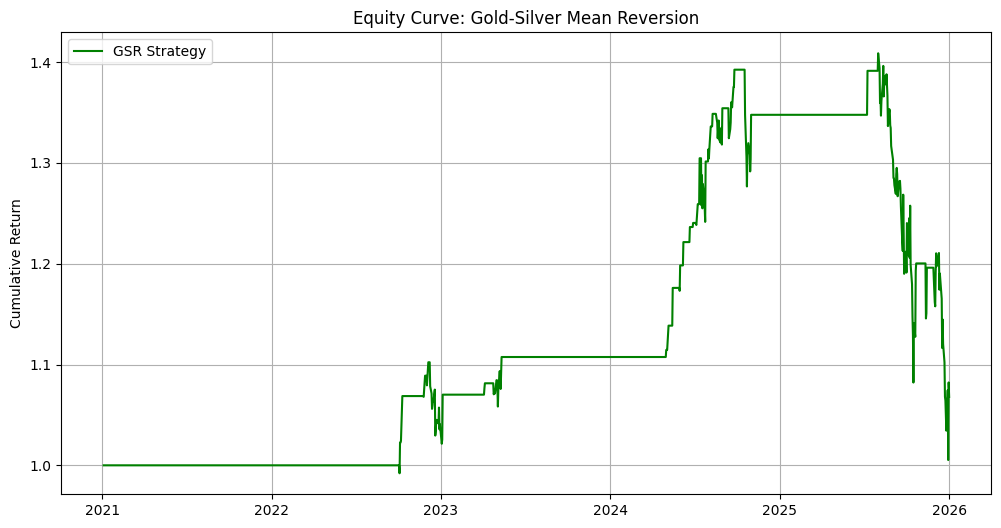

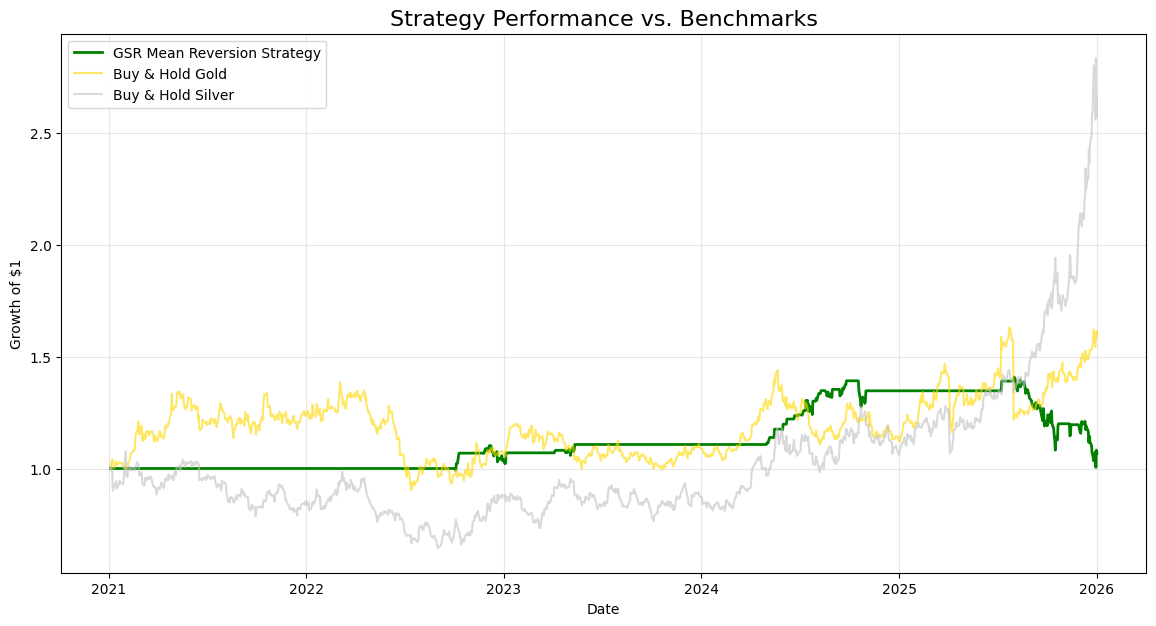

In [7]:
# Define Positions
# We stay in a trade until the Z-Score returns to 0 (Mean Reversion)
df['Signal'] = 0
df.loc[df['Z_Score'] > 2, 'Signal'] = -1  # Short the Ratio
df.loc[df['Z_Score'] < -2, 'Signal'] = 1   # Long the Ratio

# Smooth the signals and avoid flickering trades
# use .ffill() to stay in the position until the exit condition (0) is met
df['Position'] = df['Signal'].shift(1) # Shift by 1 to avoid Look-Ahead Bias

# Calculate Returns
# Strategy Return = Position * (Gold Return - Silver Return)
df['Gold_Ret'] = df['Gold'].pct_change()
df['Silver_Ret'] = df['Silver'].pct_change()
df['Strategy_Ret'] = df['Position'] * (df['Gold_Ret'] - df['Silver_Ret'])

# Cumulative Returns
df['Cum_Strategy_Ret'] = (1 + df['Strategy_Ret'].fillna(0)).cumprod()

# Plot the Equity Curve
plt.figure(figsize=(12, 6))
plt.plot(df['Cum_Strategy_Ret'], label='GSR Strategy', color='green')
plt.title('Equity Curve: Gold-Silver Mean Reversion')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()
plt.show()

# 1. Calculate Benchmark Returns (Buy & Hold)
df['Cum_Gold_Ret'] = (1 + df['Gold_Ret'].fillna(0)).cumprod()
df['Cum_Silver_Ret'] = (1 + df['Silver_Ret'].fillna(0)).cumprod()

# 2. Plot everything together
plt.figure(figsize=(14, 7))

# Plot our Strategy
plt.plot(df['Cum_Strategy_Ret'], label='GSR Mean Reversion Strategy', color='green', linewidth=2)

# Plot Benchmarks
plt.plot(df['Cum_Gold_Ret'], label='Buy & Hold Gold', color='gold', alpha=0.6, linestyle='-')
plt.plot(df['Cum_Silver_Ret'], label='Buy & Hold Silver', color='silver', alpha=0.6, linestyle='-')

# Formatting
plt.title('Strategy Performance vs. Benchmarks', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Growth of $1')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()